# Dermatologist AI

This artificial neural networks classifies the following kinds of skin marks:
* **melanoma**: this term will be used for _malignant melanoma_ (https://en.wikipedia.org/wiki/Melanoma)
* **nevus**: it is a birthmark (https://en.wikipedia.org/wiki/Nevus)
* **seborreic keratosis**: it is a benign skin tumour (https://en.wikipedia.org/wiki/Seborrheic_keratosis)

## Import the datasets

## Content of the dataset

In [4]:
import numpy as np
from glob import glob

classes_names = ['melanoma', 'nevus', 'seborrheic_keratosis']
datasets_names = ['train', 'valid', 'test']

melanoma_files_count = dict()
nevus_files_count = dict()
seborrheic_keratosis_files_count = dict()

for dataset_name in datasets_names:
    melanoma_files_count[dataset_name] = len(np.array(glob(f"data/{dataset_name}/melanoma/*")))
    nevus_files_count[dataset_name] = len(np.array(glob(f"data/{dataset_name}/nevus/*")))
    seborrheic_keratosis_files_count[dataset_name] = len(np.array(glob(f"data/{dataset_name}/seborrheic_keratosis/*")))
    
print('Number of images')
print('                      train\tvalid\ttest')
print('Melanoma:             {}\t{}\t{}'.format(melanoma_files_count['train'], melanoma_files_count['valid'], melanoma_files_count['test']))
print('Nevus:                {}\t{}\t{}'.format(nevus_files_count['train'], nevus_files_count['valid'], nevus_files_count['test']))
print('Seborrheic keratosis: {}\t{}\t{}'.format(seborrheic_keratosis_files_count['train'], seborrheic_keratosis_files_count['valid'], seborrheic_keratosis_files_count['test']))
print('-----------------------------------------------')
total_train = melanoma_files_count['train'] + nevus_files_count['train'] + seborrheic_keratosis_files_count['train']
total_valid = melanoma_files_count['valid'] + nevus_files_count['valid'] + seborrheic_keratosis_files_count['valid']
total_test = melanoma_files_count['test'] + nevus_files_count['test'] + seborrheic_keratosis_files_count['test']
print('Total:                {}\t{}\t{}'.format(total_train, total_valid, total_test))


Number of images
                      train	valid	test
Melanoma:             374	30	117
Nevus:                1372	78	393
Seborrheic keratosis: 254	42	90
-----------------------------------------------
Total:                2000	150	600


# Models

## ResNet

Based on https://arxiv.org/ftp/arxiv/papers/1703/1703.03108.pdf

### Create the dataloaders

In [33]:
from dataloading import make_dataloaders
import torchvision.transforms as transforms

resnet_transforms = \
{
    'train': transforms.Compose([transforms.Resize(224),
                                 transforms.RandomRotation(10),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])]),
    'valid': transforms.Compose([transforms.Resize(224),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])]),
    'test': transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])]),
}

resnet_subset_size = \
{
    'train': 1,
    'valid': 1,
    'test': 1
}

resnet_dataloaders = make_dataloaders(resnet_transforms, 
                                      subset_size=resnet_subset_size,
                                      batch_size=32)

train on 2000 samples out of 2000 (100%)
valid on 150 samples out of 150 (100%)
test on 600 samples out of 600 (100%)


### Transfer learning from ResNet (50 layers)

In [2]:
import torchvision.models as models

# Load ResNet 
resnet_model = models.resnet50(pretrained=True)


In [5]:
import torch.nn as nn
import torch

# Freeze training for all parameters...
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor
for param in resnet_model.parameters():
    param.requires_grad = False

# ... and replace the last layer to fit the dermatologist-ai problem.
features_count = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(features_count, len(classes_names))

use_cuda = torch.cuda.is_available()

if use_cuda:
    resnet_model.cuda()

resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

### Train

In [6]:
import torch.optim as optim
import numpy as np

resnet_criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.SGD(resnet_model.parameters(), lr=0.01)

In [7]:
import matplotlib.pyplot as plt                        
from matplotlib.pyplot import show

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    
    show(block=False)

    return ax

In [36]:
import copy

def train(n_epochs, loaders, model, optimizer, criterion, save_path):
    """returns trained model"""
    
    use_cuda = torch.cuda.is_available()

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            #if batch_idx % 100 == 0:
            #    img = copy.deepcopy(data[0])
            #    print("train image")
            #    imshow(img, normalize=True)

            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## find the loss and update the model parameters accordingly
            
            optimizer.zero_grad()
            output = model(data)
                      
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            #if batch_idx % 100 == 0:
            #    print(f"epoch: {epoch}, batch: {batch_idx} | train_loss: {train_loss}")
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            #if batch_idx % 100 == 0:
            #    img = copy.deepcopy(data[0])
            #    print("validation image") 
            #    imshow(img, normalize=True)

            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)

            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
                
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                  valid_loss_min, valid_loss))

            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [37]:
# train the model
# model_scratch.apply(weights_init_normal)
resnet_model = train(100, resnet_dataloaders, resnet_model,
                     resnet_optimizer, resnet_criterion,
                     'resnet_model.pt')


Epoch: 1 	Training Loss: 0.720481 	Validation Loss: 0.763646
Validation loss decreased (inf --> 0.763646).  Saving model ...
Epoch: 2 	Training Loss: 0.694397 	Validation Loss: 0.800227


KeyboardInterrupt: 

### Test

In [38]:
def test(loaders, model, criterion):
    use_cuda = torch.cuda.is_available()
    
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
                
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [10]:
## load the model that got the best validation accuracy
resnet_model.load_state_dict(torch.load('resnet_model.pt'))
    
use_cuda = torch.cuda.is_available()    
if use_cuda:
    resnet_model.cuda()
    
# call test function    
test(resnet_dataloaders, resnet_model, resnet_criterion)

Test Loss: 0.816448


Test Accuracy: 65% (394/600)


### Export results to CSV

In [62]:
from testing import test_images_paths
from PIL import Image

def export_to_csv(loaders, model, csv_output_path):
    use_cuda = torch.cuda.is_available()

    classes_names = loaders['train'].dataset.classes
    test_transform = loaders['test'].dataset.transform
    melanoma_index = classes_names.index('melanoma')
    seborrheic_keratosis_index = classes_names.index('seborrheic_keratosis')
    
    model.eval()
    lines = []
    for image_path in test_images_paths:
        image = Image.open(image_path)
        image = test_transform(image)
        data = torch.unsqueeze(image, 0)
        
        # move to GPU
        if use_cuda:
            data = data.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        output = output.view(3)
        
        melanoma_proba = output[melanoma_index]
        seborrheic_keratosis_proba = output[seborrheic_keratosis_index]
        
        lines.append("{},{},{}\n".format(image_path, melanoma_proba, seborrheic_keratosis_proba))
        
    csv = open(csv_output_path, 'w')
    csv.write("Id,task_1,task_2\n")
    csv.writelines(lines)
    csv.close()


In [63]:
export_to_csv(resnet_dataloaders, resnet_model, "resnet_results.csv")

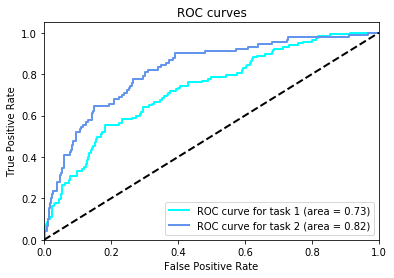

Category 1 Score: 0.729
Category 2 Score: 0.818
Category 3 Score: 0.773


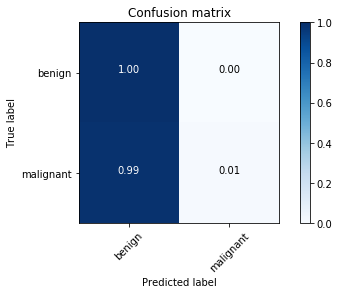

In [64]:
from get_results import get_results

get_results("resnet_results.csv")